# Introduction

As a group, we have decided to explore whether we can accurately predict pollution levels based on historical data using time series modeling. Specifically, we have chosen to investigate the use of an LSTM (Long Short-Term Memory) model, comparing its performance against a baseline ARIMA model in terms of both accuracy and computational efficiency.

My task is to reduce the complexity of the LSTM model to improve its computational performance (runtime) without sacrificing too much accuracy.

In this notebook, I will perform some exploratory data analysis (EDA) on the dataset, focusing particularly on how the pollution feature relates to other variables. The goal is to determine whether a univariate LSTM model is appropriate, which would help simplify the model and reduce the time required for training and inference. It's important to consider that, if we were to run the LSTM model on a much larger dataset (e.g., spanning 15 years), the computational feasibility of the approach becomes a key consideration.


We will first perform any necessary preprocessing to the data based on our exploration.

In [173]:
import numpy as np
import pandas as pd
import pickle 
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.graphics.api as sm
from sklearn.metrics import r2_score
from statsmodels.graphics.tsaplots import plot_pacf
import matplotlib.cm as cm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss

In [159]:
df = pd.read_csv('LSTM-Multivariate_pollution.csv')
df.head()


,date,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
0,2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
1,2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2,2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
3,2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
4,2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0


In [160]:
df.shape

(43800, 9)

In [161]:
df.isnull().sum()

date         0
pollution    0
dew          0
temp         0
press        0
wnd_dir      0
wnd_spd      0
snow         0
rain         0
dtype: int64

In [176]:
df.describe()

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
count,43800.000000,43800.000000,43800.000000,43800.000000,43800.000000,43800.000000,43800.000000,43800.000000
mean,94.013516,1.828516,12.459041,1016.447306,2.637032,23.894307,0.052763,0.195023
std,92.252276,14.429326,12.193384,10.271411,0.942265,50.022729,0.760582,1.416247
min,0.000000,-40.000000,-19.000000,991.000000,1.000000,0.450000,0.000000,0.000000
25%,24.000000,-10.000000,2.000000,1008.000000,2.000000,1.790000,0.000000,0.000000
50%,68.000000,2.000000,14.000000,1016.000000,3.000000,5.370000,0.000000,0.000000
75%,132.250000,15.000000,23.000000,1025.000000,3.000000,21.910000,0.000000,0.000000
max,994.000000,28.000000,42.000000,1046.000000,4.000000,585.600000,27.000000,36.000000


## Preprocessing 

No missing data and only one catergorical column makes preprocessing very quick

In [162]:
print(df.wnd_dir.unique())


['SE' 'cv' 'NW' 'NE']


In [163]:
mapping = {
    'NE': 1,
    'SE': 2,
    'NW': 3,
    'cv': 4
}

df.wnd_dir = df.wnd_dir.map(mapping)
df.head()

,date,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
0,2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,2,1.79,0,0
1,2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,2,2.68,0,0
2,2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,2,3.57,0,0
3,2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,2,5.36,1,0
4,2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,2,6.25,2,0


In [151]:
unmapped_values = df[df.wnd_dir.isna()]['wnd_dir'].unique()
print(unmapped_values)


[nan]


## Feature Analysis

Lets first test for correlation between features, if we see low correlation with our target feature of pollution it may back the feasibilty of a single variate model.

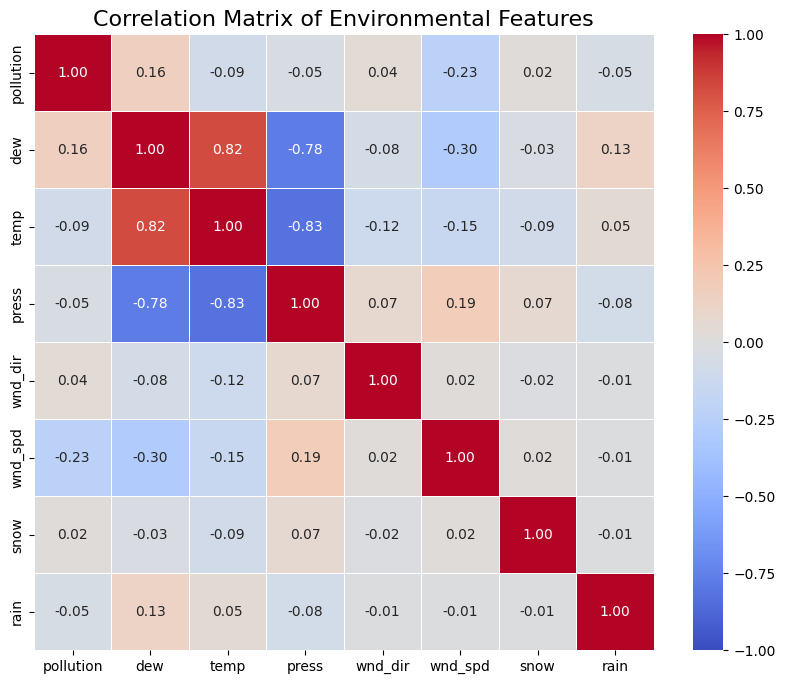

In [164]:
df_cor = df.drop(columns=['date'])

corr_matrix = df_cor.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, vmin=-1, vmax=1)

plt.title('Correlation Matrix of Environmental Features', fontsize=16)
plt.show()

The maximum correlation between pollution and other features is -0.23, which can be considered a weak to moderate correlation.

Given this, we will examine how pollution relates to its own values from previous time steps, specifically how far forward pollution at time step t can influence pollution at time stept+i.

To illustrate this, we will use a PACF (Partial Autocorrelation Function) plot. The PACF measures the correlation between two observations in a time series that are k time steps apart, while accounting for the effects of intermediate observations (at k−1,k−2,etc.). This helps identify the extent of the lag that pollution at time t has on future pollution values.


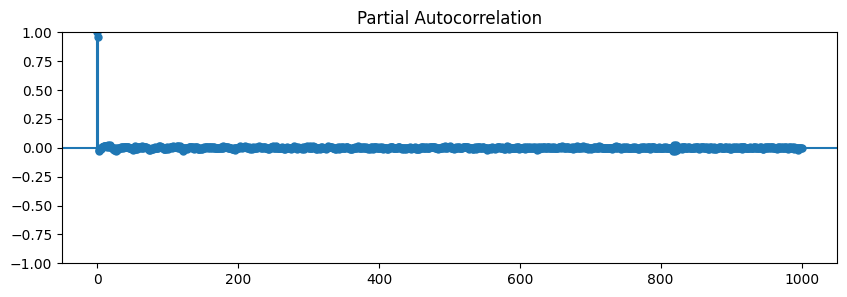

In [178]:
fig, ax = plt.subplots(figsize=(10, 3))
plot_pacf(df['pollution'], lags=1000, ax=ax)
plt.show()

It is clear that the lag is not over a large time frame, so we will shorter our search.

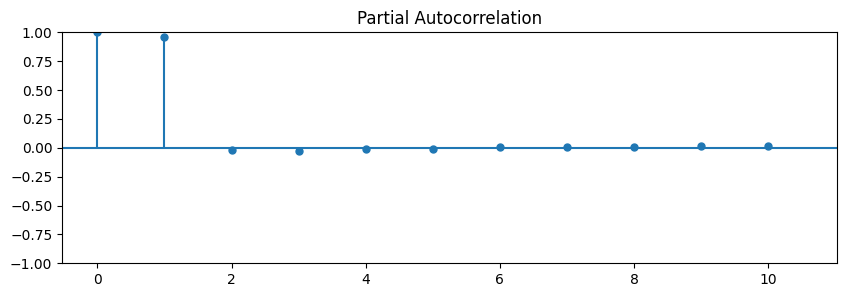

In [180]:
fig, ax = plt.subplots(figsize=(10, 3))
plot_pacf(df['pollution'], lags=10, ax=ax)
plt.show()

It appears that only the time step immediately prior to a point has a direct impact on the pollution at that time step.

We will now create a series of lag plots up to 10 hours to observe the correlation in pollution, regardless of whether it is influenced by intermediate observations.

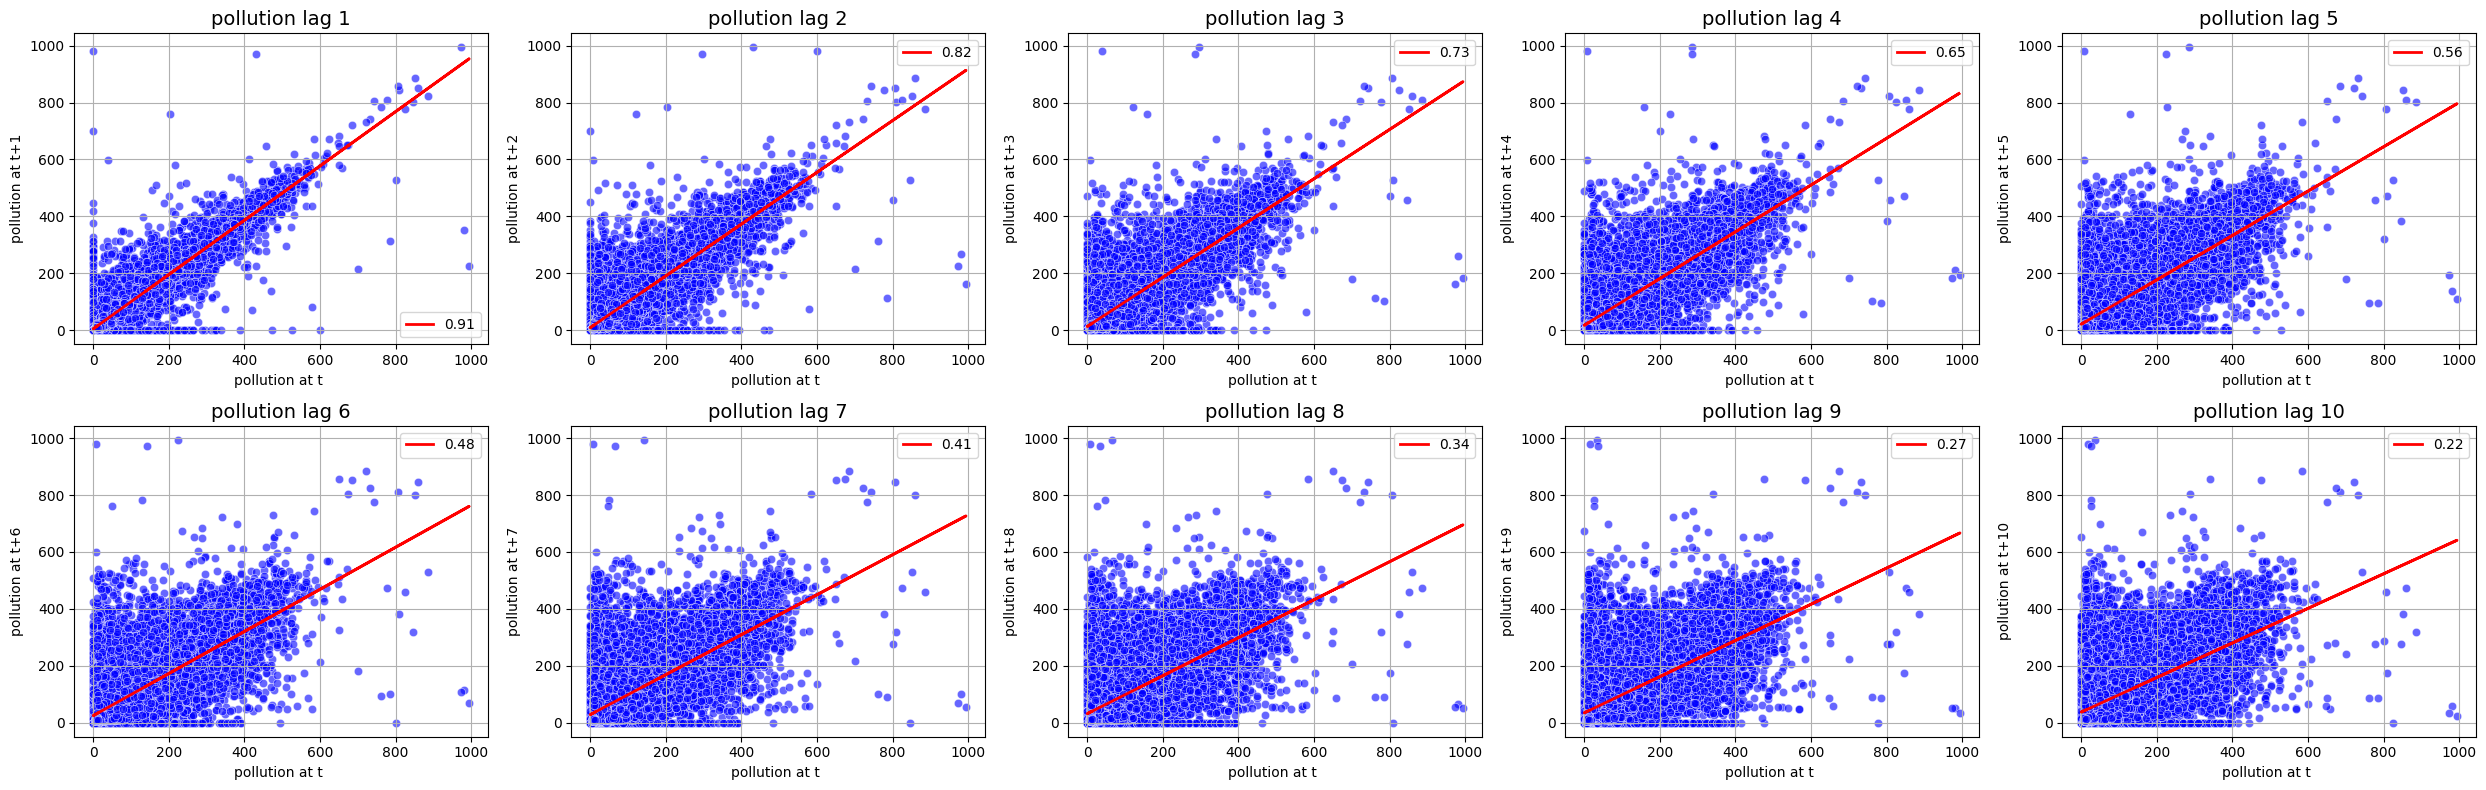

In [179]:
def lag_plot(dataframe, lag, column):
    df_copy = dataframe.copy()

    # Number of columns per row in the subplot grid
    nbr_col_per_line = 5
    n_row = (lag // nbr_col_per_line) + (lag % nbr_col_per_line > 0)
    n_col = min(lag, nbr_col_per_line)

    # Create a figure with dynamic subplots based on lag number
    fig, axes = plt.subplots(nrows=n_row, ncols=n_col, figsize=(n_col * 5, n_row * 4))
    axes = axes.flatten()  # Flatten to iterate easily over axes

    # Create lagged columns in the dataframe
    for i in range(1, lag + 1):
        df_copy[f'{column}_lag_{i}'] = df_copy[column].shift(i)
    df_copy = df_copy.dropna()  

    #Plot of each lag
    for i in range(lag):
        x = df_copy[column]
        y = df_copy[f'{column}_lag_{i+1}']
        
        m, b = np.polyfit(x, y, 1)
        r_squared = r2_score(x, y)
        
        ax = axes[i]
        sns.scatterplot(x=x, y=y, ax=ax, color='blue', alpha=0.6)
        ax.plot(x, m*x+b, color='red', linewidth=2, label="%.2f" % r_squared)
        
        ax.set_title(f'{column} lag {i+1}', fontsize=14)
        ax.set_xlabel(f'{column} at t ', fontsize=10)
        ax.set_ylabel(f'{column} at t+{i + 1}', fontsize=10)
        ax.grid(True)
        ax.legend()

    plt.tight_layout()
    plt.show()

lag_plot(df, lag=10, column='pollution')

## Refined up to this point

In [167]:
print(df.columns)

Index(['date', 'pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd',
       'snow', 'rain'],
      dtype='object')


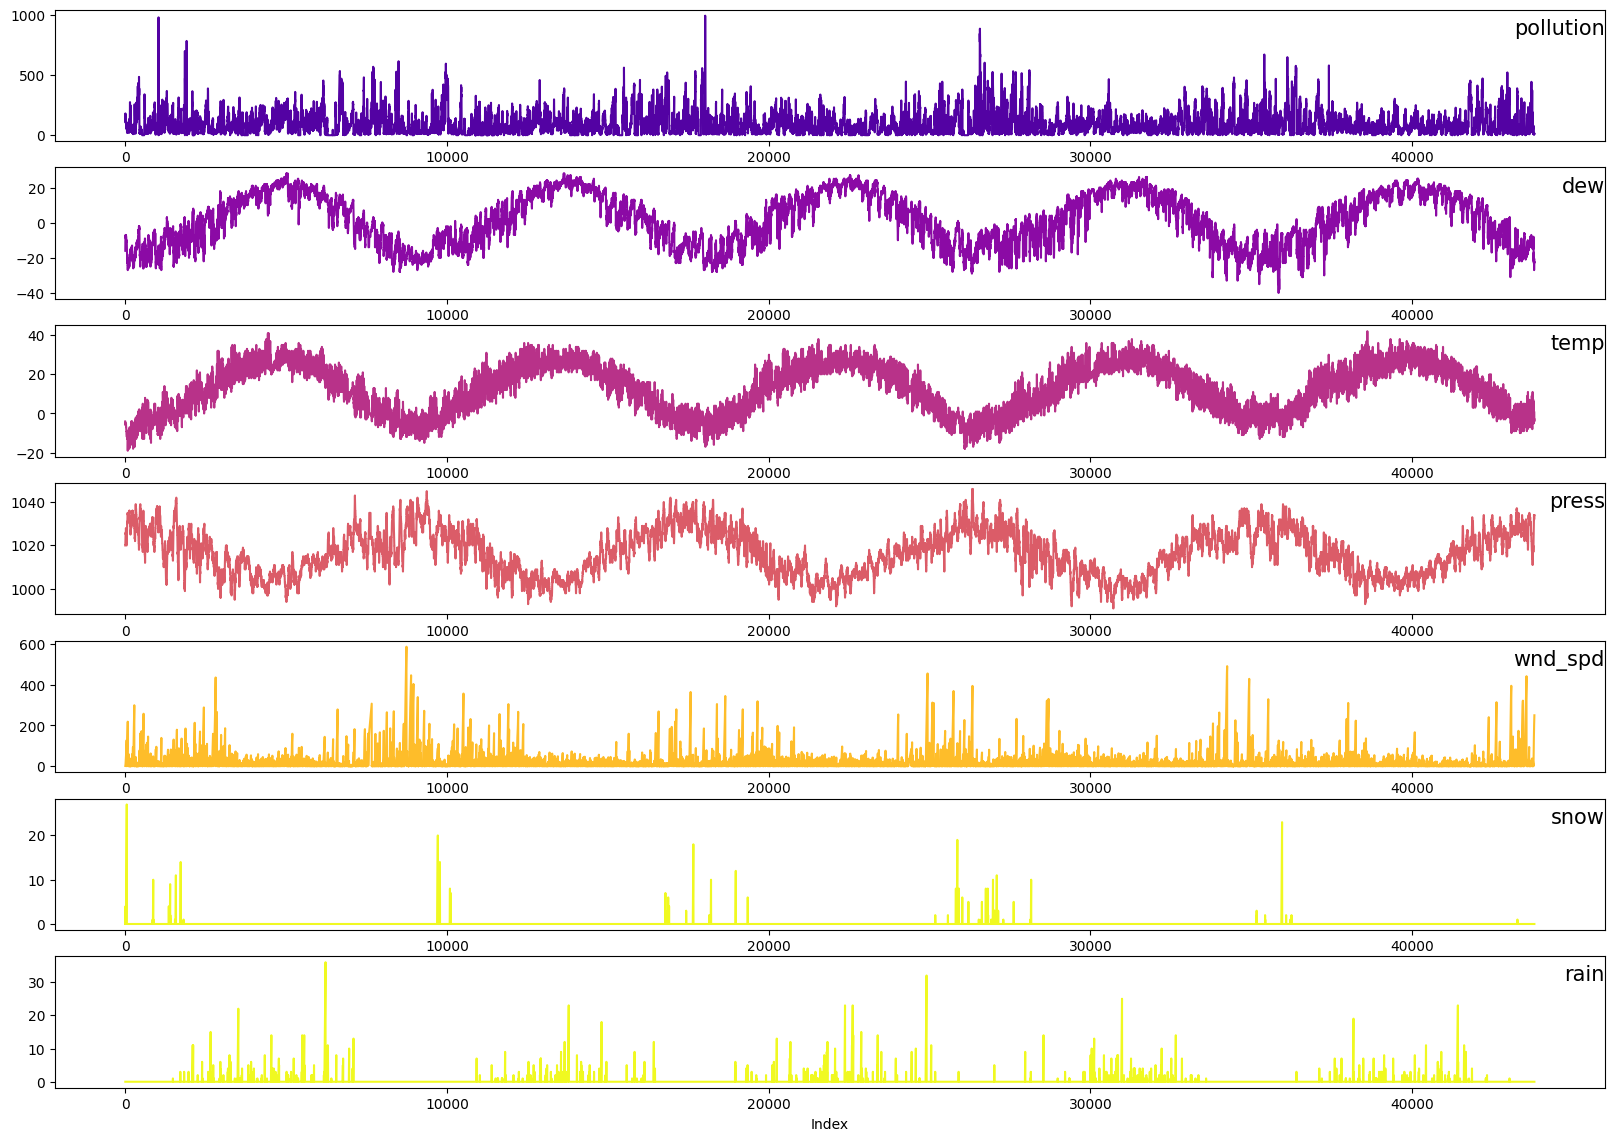

In [168]:
values = df.values

# specify columns to plot
groups = [1, 2, 3, 4, 6, 7, 8]
i = 1

# plot each column
plt.figure(figsize=(20,14))
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group], color=cm.plasma(group/len(groups)))
    plt.xlabel('Index')
    plt.title(df.columns[group], y=0.75, loc='right', fontsize = 15)
    i += 1
plt.show()

Something about low correlation so could simplify model for complexity and computational time to just a single vairate model. #rough

No obvious seasonal trends in the pollution data, hence using the lag data from earlier suggesting that only the timestep before has a large bearing on the pollution level, we can say it would be appropiate to use a moving window validation method. 
#something along these lines with more depth 

## Statistical Tests for Stationary Time Series Data

This is not really to big of a concern with an LSTM model as RNNs are  able to capture nonlinearites much better than ARIMA, which will need to be adjusted such that the model is not affected by non-stationary data. We expect this to be the case for seasonal data such as temp, dew and press.

However for the purposes of performance it might be useful to know if pollution has any long term changing of mean (or other statistics), or has any seasonal trends, as this might give us an insight to how why the model performs the way it is. For instance, if it is stationary it might make the learning process of the RNN easier.

There are 2 tests that are often used in conjucture of eachother. The Augmented Dickey-Fuller (ADF) test is used to check for the presence of a unit root in the data, suggesting that the data evolves in a particular way over time, hence the data has changing statistics and is not stationary. The idea is that the data does not return to long term mean. The other is the Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test which checks for trend stationarity, for example if the data is increasing in time, the fluctations around the trend are stationary if KPSS test fails to reject null.

Code resource and information: https://www.analyticsvidhya.com/blog/2021/06/statistical-tests-to-check-stationarity-in-time-series-part-1/

In [170]:
def adf_test(timeseries):
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

adf_test(df['pollution'])


Results of Dickey-Fuller Test:
Test Statistic                   -21.004109
p-value                            0.000000
#Lags Used                        55.000000
Number of Observations Used    43744.000000
Critical Value (1%)               -3.430499
Critical Value (5%)               -2.861606
Critical Value (10%)              -2.566805
dtype: float64


In [174]:
def kpss_test(timeseries):
    print ('Results of KPSS Test:')
    kpsstest = kpss(timeseries, regression='c', nlags="auto")
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','#Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print (kpss_output)

kpss_test(df['pollution'])   

Results of KPSS Test:
Test Statistic             0.078133
p-value                    0.100000
#Lags Used               114.000000
Critical Value (10%)       0.347000
Critical Value (5%)        0.463000
Critical Value (2.5%)      0.574000
Critical Value (1%)        0.739000
dtype: float64


/var/folders/zj/y_2y230d1z18y9001xkg2qgw0000gn/T/ipykernel_36358/1476954903.py:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpsstest = kpss(timeseries, regression='c', nlags="auto")


As we can see, the pollution data has evidence to reject the null hypothesis at p=0.01 in the ADF test suggesting stationarity.
Also, there is not sufficient evidence to reject null at p=0.01 in the KPSS test, also suggesting stationarity.

We looked only at pollution trends, as we are building a single variate model on pollution. These tests will be used further by Christian when investigating his ARIMA model implementation.